In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 팔당댐 홍수 안전운영에 따른 한강 수위예측 AI

최근 기후변화로 인해 홍수 등의 자연재해가 지속적으로 발생함에 따라, 홍수 피해를 최소화하여 국민의 생명과 안전을 지키는 댐의 역할은 매우 중요해지고 있습니다.

팔당댐은 한국수력원자력이 관리, 운영 중인 댐으로, 서울 및 수도권의 홍수 방어에 있어 최후의 보루 역할을 하고 있는 중요한 댐입니다.

팔당댐의 홍수 안전운영에 따른 서울시내 한강 주요지점의 수위를 예측하여 홍수재해로 인한 피해를 미연에 방지하고 최소화 할 수 있지 않을까요?

In [ ]:
### 환경설정


## 1.기본
import numpy as np  # numpy 패키지 가져오기
import matplotlib.pyplot as plt # 시각화 패키지 가져오기

## 2.데이터 가져오기
import pandas as pd # csv -> dataframe으로 전환
from sklearn import datasets # python 저장 데이터 가져오기

## 4. 훈련/검증용 데이터 분리
from sklearn.model_selection import train_test_split 

## 5.분류모델구축
from sklearn.tree import DecisionTreeClassifier # 결정 트리
from sklearn.neighbors import KNeighborsClassifier # K-최근접 이웃
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀 모델
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

## 5_1.앙상블 모델 구축
from sklearn.ensemble import VotingClassifier # 과반수 투표(Majority Voting) 

## 6.모델검정
from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score # 정확도, 민감도 등
from sklearn.metrics import roc_curve, auc # ROC 곡선 그리기

## 7.최적화
from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV # 하이퍼파라미터 튜닝
from sklearn.model_selection import cross_val_score # 교차타당도 # 추가

## 8. 데이터 전처리
from sklearn.preprocessing import StandardScaler # 표준화
from sklearn.preprocessing import MinMaxScaler # 정규화
from sklearn.preprocessing import LabelEncoder # 문자형 변수를 숫자형 변수로 변경
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

## 9. 데이터 시각화
import pandas as pd
import seaborn as sns
from scipy import stats # 확률분포 분석할때와 해당 그래프 그릴 경우 필요
import plotly.express as px 
## 10. 경고무시
import warnings
warnings.filterwarnings('ignore')

## 11. Tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential # Sequential 형태의 모델을 만들어줌
from tensorflow.keras import layers #Dense를 만들때 사용
from tensorflow.keras import activations # activation을 만들 때 사용
from tensorflow.keras.layers import Dense, Activation, Flatten, Input # 전부 다 불러오는 방법
from tensorflow.keras.utils import plot_model # 모델을 시각화

# 12. 파일 불러오기
from glob import glob

In [ ]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
# 여기까지 실행 후 "런타임 다시 시작..." 실행 (이 부분은 실행할 필요 없음)

Selecting previously unselected package fonts-nanum.
(Reading database ... 155676 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
# Data
# ├ Water Data

# │ ├ data_2012.csv

# │   ├ ymdhm : 년월일시분

# │   ├ swl : 팔당댐 현재수위 (단위: El.m)

# │   ├ inf : 팔당댐 유입량 (단위: m^3/s)  

# │   ├ sfw : 팔당댐 저수량 (단위: 만m^3)

# │   ├ ecpc : 팔당댐 공용량 (단위: 백만m^3)

# │   ├ tototf : 총 방류량 (단위: m^3/s)

# │   ├ tide_level : 강화대교 조위 (단위: cm)   # 조위 - 일정한 기준면에서 해면을 측정했을 때의 높이를 말한다.

# │   ├ wl_1018662 : 청담대교 수위 (단위: cm)   

# │   ├ fw_1018662 : 청담대교 유량 (단위: m^3/s)   # 유량 -  단위시간동안 흐르는 유체의 양

# │   ├ wl_1018680 : 잠수교 수위 (단위: cm)

# │   ├ fw_1018680 : 잠수교 유량 (단위: m^3/s)

# │   ├ wl_1018683 : 한강대교 수위 (단위: cm)

# │   ├ fw_1018683 : 한강대교 유량 (단위: m^3/s)

# │   ├ wl_1019630 : 행주대교 수위 (단위: cm)

# │   └ fw_1019630 : 행주대교 유량 (단위: m^3/s)

# │ ├ data_2013.csv

# …

# └ └ data_2022.csv

# └ RainFall Data

# │ ├ rf_2012.csv

# │   ├ YMDHM : 년월일시분

# │   ├ rf_10184100 : 대곡교 강수량

# │   ├ rf_10184110 : 진관교 강수량

# │   └ rf_10184140 : 송정동 강수량

# │ ├ rf_2013.csv

# …

# └ └ rf_2022.csv

In [ ]:
# 물 데이터 water_data 불러오기

w_list = sorted(glob("/content/drive/MyDrive/ITstudy(SeongMin)/팔당댐 공모전/water_data/*.csv"))

water_data = pd.DataFrame()
for i in w_list:
    data = pd.read_csv(i)
    water_data = water_data.append(data)

water_data.rename(columns = {'ymdhm' : '년월일시분',  # 가독성을 위해 컬럼명 변경
                             'swl' : '팔당댐 현재수위 (단위: El.m)',
                             'inf' : '팔당댐 유입량 (단위: m^3/s)',
                             'sfw' : '팔당댐 저수량 (단위: 만m^3)',
                             'ecpc' : '팔당댐 공용량 (단위: 백만m^3)',
                             'tototf' : '총 방류량 (단위: m^3/s)',
                             'tide_level' : '강화대교 조위 (단위: cm)',
                             'wl_1018662' : '청담대교 수위 (단위: cm)',
                             'fw_1018662' : '청담대교 유량 (단위: m^3/s)',
                             'wl_1018680' : '잠수교 수위 (단위: cm)',
                             'fw_1018680' : '잠수교 유량 (단위: m^3/s)',
                             'wl_1018683' : '한강대교 수위 (단위: cm)',
                             'fw_1018683' : '한강대교 유량 (단위: m^3/s)',
                             'wl_1019630' : '행주대교 수위 (단위: cm)',
                             'fw_1019630' : '행주대교 유량 (단위: m^3/s)'}, inplace = True)



# 강수량(rainfall) 데이터 csv불러오기

w_list1 = sorted(glob("/content/drive/MyDrive/ITstudy(SeongMin)/팔당댐 공모전/rf_data/*.csv"))
w_list1

rf_data = pd.DataFrame()
for i in w_list1:
    data = pd.read_csv(i)
    rf_data = rf_data.append(data)

rf_data.rename(columns = {'ymdhm' : '년월일시분',     # 가독성을 위해 컬럼명 변경
                             'rf_10184100' : '대곡교 강수량',
                             'rf_10184110' : '진관교 강수량',
                             'rf_10184140' : '송정동 강수량'}, inplace = True)



# 데이터 프레임 합치기 (merge를 이용해 중복된 컬럼 제거)

water_datas = pd.merge(water_data, rf_data, how = 'left', on = '년월일시분') 
# how = '~로' , on = ' 입력값을 기준으로 '

In [ ]:
water_data

,년월일시분,팔당댐 현재수위 (단위: El.m),팔당댐 유입량 (단위: m^3/s),팔당댐 저수량 (단위: 만m^3),팔당댐 공용량 (단위: 백만m^3),총 방류량 (단위: m^3/s),강화대교 조위 (단위: cm),청담대교 수위 (단위: cm),청담대교 유량 (단위: m^3/s),잠수교 수위 (단위: cm),잠수교 유량 (단위: m^3/s),한강대교 수위 (단위: cm),한강대교 유량 (단위: m^3/s),행주대교 수위 (단위: cm),행주대교 유량 (단위: m^3/s)
0,2012-05-01 00:00,24.800,555.00,219.07,24.93,555.00,445.0,310.7,469.05,300.2,0.0,290.0,729.80,275.3,540.18
1,2012-05-01 00:10,24.794,464.60,218.86,25.15,562.90,449.0,314.7,498.00,300.2,0.0,290.0,731.48,275.3,540.18
2,2012-05-01 00:20,24.789,478.10,218.69,25.31,576.40,451.0,313.7,490.68,301.2,0.0,290.0,726.42,275.3,540.18
3,2012-05-01 00:30,24.789,464.80,218.69,25.31,563.10,452.0,311.7,476.21,301.2,0.0,290.0,726.42,276.3,552.17
4,2012-05-01 00:40,24.789,478.10,218.69,25.31,576.40,450.0,311.7,476.21,301.2,0.0,291.0,707.17,277.3,564.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11371,2022-07-18 23:10,25.040,259.23,212.86,31.14,259.23,510.0,0.0,319.84,0.0,NaN,0.0,-456.41,0.0,974.40
11372,2022-07-18 23:20,25.040,260.46,212.86,31.14,260.46,492.0,0.0,314.01,0.0,NaN,0.0,-717.30,0.0,1006.88
11373,2022-07-18 23:30,25.040,259.37,212.86,31.14,259.37,475.0,0.0,387.55,0.0,NaN,0.0,-843.37,0.0,1039.90
11374,2022-07-18 23:40,25.040,259.13,212.86,31.14,259.13,458.0,0.0,454.91,0.0,NaN,0.0,-1023.37,0.0,1073.46


In [ ]:
rf_data['년월일시분']

0        2012-05-01 00:00
1        2012-05-01 00:10
2        2012-05-01 00:20
3        2012-05-01 00:30
4        2012-05-01 00:40
               ...       
11371    2022-07-18 23:10
11372    2022-07-18 23:20
11373    2022-07-18 23:30
11374    2022-07-18 23:40
11375    2022-07-18 23:50
Name: 년월일시분, Length: 276336, dtype: object

In [ ]:
water_data # 276336 rows × 18 columns

,년월일시분,팔당댐 현재수위 (단위: El.m),팔당댐 유입량 (단위: m^3/s),팔당댐 저수량 (단위: 만m^3),팔당댐 공용량 (단위: 백만m^3),총 방류량 (단위: m^3/s),강화대교 조위 (단위: cm),청담대교 수위 (단위: cm),청담대교 유량 (단위: m^3/s),잠수교 수위 (단위: cm),잠수교 유량 (단위: m^3/s),한강대교 수위 (단위: cm),한강대교 유량 (단위: m^3/s),행주대교 수위 (단위: cm),행주대교 유량 (단위: m^3/s)
0,2012-05-01 00:00,24.800,555.00,219.07,24.93,555.00,445.0,310.7,469.05,300.2,0.0,290.0,729.80,275.3,540.18
1,2012-05-01 00:10,24.794,464.60,218.86,25.15,562.90,449.0,314.7,498.00,300.2,0.0,290.0,731.48,275.3,540.18
2,2012-05-01 00:20,24.789,478.10,218.69,25.31,576.40,451.0,313.7,490.68,301.2,0.0,290.0,726.42,275.3,540.18
3,2012-05-01 00:30,24.789,464.80,218.69,25.31,563.10,452.0,311.7,476.21,301.2,0.0,290.0,726.42,276.3,552.17
4,2012-05-01 00:40,24.789,478.10,218.69,25.31,576.40,450.0,311.7,476.21,301.2,0.0,291.0,707.17,277.3,564.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11371,2022-07-18 23:10,25.040,259.23,212.86,31.14,259.23,510.0,0.0,319.84,0.0,NaN,0.0,-456.41,0.0,974.40
11372,2022-07-18 23:20,25.040,260.46,212.86,31.14,260.46,492.0,0.0,314.01,0.0,NaN,0.0,-717.30,0.0,1006.88
11373,2022-07-18 23:30,25.040,259.37,212.86,31.14,259.37,475.0,0.0,387.55,0.0,NaN,0.0,-843.37,0.0,1039.90
11374,2022-07-18 23:40,25.040,259.13,212.86,31.14,259.13,458.0,0.0,454.91,0.0,NaN,0.0,-1023.37,0.0,1073.46


# 데이터 시각화

시각화를 통해 변수들간 상관관계를 가볍게 살펴보았습니다.

In [ ]:
#water_datas = pd.read_csv('water_datas.csv', encoding = 'euc-kr')

In [ ]:
#1. 청담대교 수위와 유량의 산점도
px.scatter(water_datas[water_datas['청담대교 수위 (단위: cm)'] != 0], x = '청담대교 수위 (단위: cm)', y = '청담대교 유량 (단위: m^3/s)')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#2. 한강대교 수위와 유량의 산점도
px.scatter(water_datas[water_datas['한강대교 수위 (단위: cm)'] != 0], x = '한강대교 수위 (단위: cm)', y = '한강대교 유량 (단위: m^3/s)')

Output hidden; open in https://colab.research.google.com to view.

유량은 단위시간 당 얼마만큼의 체적에 해당하는 액체가 이동했는지 나타낼 때 쓰는 개념으로, 기준 방향으로 흐를 때 양수 값을 가지고, 반대 방향으로 흐를 때 음수 값을 가집니다.

한강대교의 경우 유량에서 - 즉 , 역류현상이 많이 보이는 편이었습니다.
시각화를 해본 결과 역류현상또한 물의 흐름 방향의 변화일 뿐이기에 유량이 많아질수록 수위가 높아지는 것의 상관관계를 확인할 수 있었습니다.

In [ ]:
#3. 행주대교 수위와 유량의 산점도
px.scatter(water_datas[water_datas['행주대교 수위 (단위: cm)'] != 0], x = '행주대교 수위 (단위: cm)', y = '행주대교 유량 (단위: m^3/s)')

Output hidden; open in https://colab.research.google.com to view.

각 대교의 수위와 유량의 산점도를 통해 뚜렷한 양의 상관관계가 존재함을 확인할 수 있습니다.

팔당댐의 방류량에 따라 각 대교의 수위는 어떻게 달라질까요?

In [ ]:
# 팔당댐 방류량과 각 대교의 수위
dat1 = pd.melt(water_datas, id_vars = ['총 방류량 (단위: m^3/s)'], value_vars = ['청담대교 수위 (단위: cm)', '한강대교 수위 (단위: cm)', '행주대교 수위 (단위: cm)'])
dat1

,총 방류량 (단위: m^3/s),variable,value
0,555.00,청담대교 수위 (단위: cm),310.7
1,562.90,청담대교 수위 (단위: cm),314.7
2,576.40,청담대교 수위 (단위: cm),313.7
3,563.10,청담대교 수위 (단위: cm),311.7
4,576.40,청담대교 수위 (단위: cm),311.7
...,...,...,...
829003,259.23,행주대교 수위 (단위: cm),0.0
829004,260.46,행주대교 수위 (단위: cm),0.0
829005,259.37,행주대교 수위 (단위: cm),0.0
829006,259.13,행주대교 수위 (단위: cm),0.0


In [ ]:
#4. 팔당댐의 방류량과 대교별 수위
px.scatter(dat1, x = '총 방류량 (단위: m^3/s)', y = 'value', color = 'variable')

Output hidden; open in https://colab.research.google.com to view.

시각화 자료와 아래 지도를 보았을 때 팔당댐에서 물을 방류함에 따라 
가까운 순서대로 청담 - 한강 - 행주 순으로 수위가 더 높게 올라가는걸 알 수 있다. 이를 통해 지리적 특성에 따라 댐에 가까울수록 상관관계가 더 높다는 걸 알 수 있었습니다.

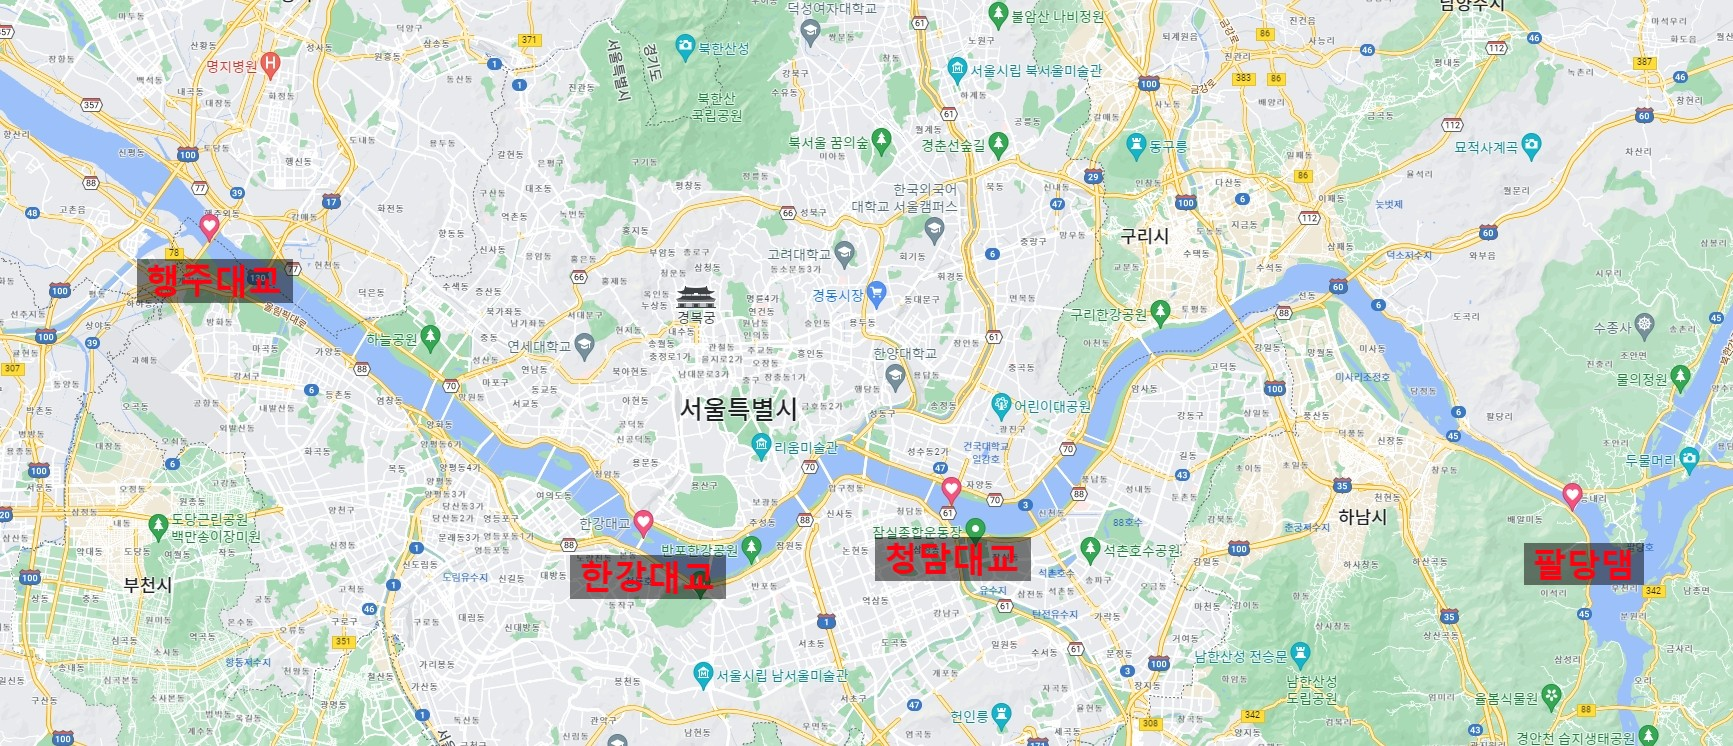

In [ ]:
# 5. 팔당댐 방류량과 각 대교의 유량
dat1 = pd.melt(water_datas, id_vars = ['총 방류량 (단위: m^3/s)'], value_vars = ['청담대교 유량 (단위: m^3/s)', '한강대교 유량 (단위: m^3/s)', '행주대교 유량 (단위: m^3/s)'])
px.scatter(dat1, x = '총 방류량 (단위: m^3/s)', y = 'value', color = 'variable')

Output hidden; open in https://colab.research.google.com to view.

한강대교가 유독 역류하는 현상을보이고 있고 나머지 청담과 행주는 비슷한 값의 추이를 보이고 있다는 것을 확인했습니다.

In [ ]:
# 6. 팔당댐 유입량과 각 대교의 유량
dat1 = pd.melt(water_datas, id_vars = ['팔당댐 유입량 (단위: m^3/s)'], value_vars = ['청담대교 수위 (단위: cm)', '한강대교 수위 (단위: cm)', '행주대교 수위 (단위: cm)'])
px.scatter(dat1, x = '팔당댐 유입량 (단위: m^3/s)', y = 'value', color = 'variable')

Output hidden; open in https://colab.research.google.com to view.

자료를 보고 위 그래프와 마찬가지로 지리적 특성이 요인이 되지 않았을까 유추해 볼 수 있겠지만, 유입량은 강수량에 따라 증가하기 때문에 강수량의 증가로 인한 대교들의 수위가 같이 올라갔음을 확인할 수 있고, 상관관계가 있다고 볼 수 있을 것 같다는 생각을 했습니다.

그리고 추가로 팔당댐 저수량과 각 대교의 유량을 시각화 하여 파악해 보았는데요, 시각화 자료가 용량때문인지 코랩이 자꾸 멈춰서 누락하게 되었습니다. 
시각화 결과 팔당댐 저수량과 각대교의 유량의 상관관계는 따로 없었습니다.

# 데이터 전처리

In [ ]:
#잠수교 수위 결측치 처리 (어차피 Drop 할거지만 혹시 몰라 주석처리)
#청담대교와 한강대교의 평균값
# water_datas['잠수교 수위 (단위: cm)'] = (water_datas['청담대교 수위 (단위: cm)'] + water_datas['한강대교 수위 (단위: cm)'])/2
# water_datas['잠수교 유량 (단위: m^3/s)'] = (water_datas['청담대교 유량 (단위: m^3/s)'] + water_datas['한강대교 유량 (단위: m^3/s)'])/2

In [ ]:
# 원본 훼손 방지를 위해 복사본 생성

water_datas2 = water_datas.copy() 

본격적으로 전처리를 진행하기 전,

1) 시각화를 통해 상관관계가 존재하지 않는 것으로 판단된 칼럼

2) 측정이 이루어지지 않아 모든 행이 결측치인 `잠수대교` 칼럼

이 칼럼들을 제거하고 진행했습니다!

In [ ]:
water_datas2.drop(['팔당댐 현재수위 (단위: El.m)', '팔당댐 저수량 (단위: 만m^3)', '팔당댐 공용량 (단위: 백만m^3)', '강화대교 조위 (단위: cm)', '잠수교 수위 (단위: cm)', '잠수교 유량 (단위: m^3/s)'], axis = 1, inplace = True)

In [ ]:
water_datas2.head()

,년월일시분,팔당댐 유입량 (단위: m^3/s),총 방류량 (단위: m^3/s),청담대교 수위 (단위: cm),청담대교 유량 (단위: m^3/s),한강대교 수위 (단위: cm),한강대교 유량 (단위: m^3/s),행주대교 수위 (단위: cm),행주대교 유량 (단위: m^3/s),대곡교 강수량,진관교 강수량,송정동 강수량
0,2012-05-01 00:00,555.0,555.0,310.7,469.05,290.0,729.80,275.3,540.18,0.0,0.0,0.0
1,2012-05-01 00:10,464.6,562.9,314.7,498.00,290.0,731.48,275.3,540.18,0.0,0.0,0.0
2,2012-05-01 00:20,478.1,576.4,313.7,490.68,290.0,726.42,275.3,540.18,0.0,0.0,0.0
3,2012-05-01 00:30,464.8,563.1,311.7,476.21,290.0,726.42,276.3,552.17,0.0,0.0,0.0
4,2012-05-01 00:40,478.1,576.4,311.7,476.21,291.0,707.17,277.3,564.29,0.0,0.0,0.0


In [ ]:
water_datas2.tail()

,년월일시분,팔당댐 유입량 (단위: m^3/s),총 방류량 (단위: m^3/s),청담대교 수위 (단위: cm),청담대교 유량 (단위: m^3/s),한강대교 수위 (단위: cm),한강대교 유량 (단위: m^3/s),행주대교 수위 (단위: cm),행주대교 유량 (단위: m^3/s),대곡교 강수량,진관교 강수량,송정동 강수량
276331,2022-07-18 23:10,259.23,259.23,0.0,319.84,0.0,-456.41,0.0,974.40,0.0,0.0,0.0
276332,2022-07-18 23:20,260.46,260.46,0.0,314.01,0.0,-717.30,0.0,1006.88,0.0,0.0,0.0
276333,2022-07-18 23:30,259.37,259.37,0.0,387.55,0.0,-843.37,0.0,1039.90,0.0,0.0,0.0
276334,2022-07-18 23:40,259.13,259.13,0.0,454.91,0.0,-1023.37,0.0,1073.46,0.0,0.0,0.0
276335,2022-07-18 23:50,258.16,258.16,0.0,582.21,0.0,-1049.44,0.0,1090.45,0.0,0.0,0.0


10분 단위의 데이터이기 때문에 **'현재 비가 내리는지'**도 중요하지만 **'그 날 비가 왔는지'**도 중요한 요소라고 생각해서

일자별 `누적강수량` 변수를 생성했습니다!

In [ ]:
# 하루의 누적강수량 계산하는 컬럼 생성하기

# 함수생성
def yymmdd(x):
    return x['년월일시분'].split(' ')[0]
    
water_datas2['년월일'] = water_datas2.apply(yymmdd, axis = 1)  # 일자까지만 입력된 column 생성

# groupby로 컬럼을 묶어 같은 날의 누적 강수량 구하기    .cumsum() = 누적합
water_datas2['대곡교 누적 강수량'] = water_datas2.groupby('년월일')['대곡교 강수량'].cumsum()

#누적 강수량 구하기
water_datas2['대곡교 누적 강수량'] = water_datas2.groupby('년월일')['대곡교 강수량'].cumsum()
water_datas2['진관교 누적 강수량'] = water_datas2.groupby('년월일')['진관교 강수량'].cumsum()
water_datas2['송정동 누적 강수량'] = water_datas2.groupby('년월일')['송정동 강수량'].cumsum()

# 누적강수량 만든 후 사용했던 컬럼 삭제
water_datas2.drop('년월일', axis = 1, inplace = True)


데이터에는 `유량` 변수가 포함되어 있습니다.

유량은 단위시간 당 얼마만큼의 체적에 해당하는 액체가 이동했는지 나타낼 때 쓰는 개념으로,

기준 방향으로 흐를 때 **양수** 값을 가지고, 반대 방향으로 흐를 때 **음수** 값을 가집니다.

유량이 가진 수치의 대소와 방향성을 모두 보여주기 위해 `유량 절댓값`, `유량 부호` 칼럼을 생성했습니다.

In [ ]:
#부호 칼럼 만들기
def sign1(x):
    if x['청담대교 유량 (단위: m^3/s)'] >= 0:
        return 1
    else:
        return 0
    
def sign2(x):
    if x['한강대교 유량 (단위: m^3/s)'] >= 0:
        return 1
    else:
        return 0
    
def sign3(x):
    if x['행주대교 유량 (단위: m^3/s)'] >= 0:
        return 1
    else:
        return 0

water_datas2['청담대교 유량 부호'] = water_datas2.apply(sign1, axis = 1)
water_datas2['한강대교 유량 부호'] = water_datas2.apply(sign2, axis = 1)
water_datas2['행주대교 유량 부호'] = water_datas2.apply(sign3, axis = 1)

#절댓값 칼럼 만들기
water_datas2['청담대교 유량_abs'] = abs(water_datas2['청담대교 유량 (단위: m^3/s)'])
water_datas2['한강대교 유량_abs'] = abs(water_datas2['한강대교 유량 (단위: m^3/s)'])
water_datas2['행주대교 유량_abs'] = abs(water_datas2['행주대교 유량 (단위: m^3/s)'])

# 유량 데이터를 쪼갰으니 원래 유량데이터는 삭제

water_datas2.drop(['청담대교 유량 (단위: m^3/s)', '한강대교 유량 (단위: m^3/s)', '행주대교 유량 (단위: m^3/s)'], axis = 1, inplace = True)

In [ ]:
water_datas2.head()

,년월일시분,팔당댐 유입량 (단위: m^3/s),총 방류량 (단위: m^3/s),청담대교 수위 (단위: cm),한강대교 수위 (단위: cm),행주대교 수위 (단위: cm),대곡교 강수량,진관교 강수량,송정동 강수량,대곡교 누적 강수량,진관교 누적 강수량,송정동 누적 강수량,청담대교 유량 부호,한강대교 유량 부호,행주대교 유량 부호,청담대교 유량_abs,한강대교 유량_abs,행주대교 유량_abs
0,2012-05-01 00:00,555.0,555.0,310.7,290.0,275.3,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,469.05,729.80,540.18
1,2012-05-01 00:10,464.6,562.9,314.7,290.0,275.3,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,498.00,731.48,540.18
2,2012-05-01 00:20,478.1,576.4,313.7,290.0,275.3,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,490.68,726.42,540.18
3,2012-05-01 00:30,464.8,563.1,311.7,290.0,276.3,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,476.21,726.42,552.17
4,2012-05-01 00:40,478.1,576.4,311.7,291.0,277.3,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,476.21,707.17,564.29


In [ ]:
# water_datas2 데이터프레임에 우리가 예측해야 할 기간 (2022.06.01~2022.07.18)이 포함되어 있기 때문에
# train, test 데이터 셋으로 split을 해줌 -> 하드코딩방식이기 때문에 추후에 소프트 코딩으로 바꾸고 싶음

train_data = water_datas2.loc[:269423]    # 훈련용 데이터
test_data = water_datas2.loc[269424:]   # 우리가 예측해야 할 기간

In [ ]:
# 복사본

train_data2= train_data.copy()
test_data2 = test_data.copy()

In [ ]:
# train 데이터 셋만 null 값 드랍
train_data2.dropna(inplace = True)

# 잘 되었는지 확인
train_data2.isnull().sum()

년월일시분                  0
팔당댐 유입량 (단위: m^3/s)    0
총 방류량 (단위: m^3/s)      0
청담대교 수위 (단위: cm)       0
한강대교 수위 (단위: cm)       0
행주대교 수위 (단위: cm)       0
대곡교 강수량                0
진관교 강수량                0
송정동 강수량                0
대곡교 누적 강수량             0
진관교 누적 강수량             0
송정동 누적 강수량             0
청담대교 유량 부호             0
한강대교 유량 부호             0
행주대교 유량 부호             0
청담대교 유량_abs            0
한강대교 유량_abs            0
행주대교 유량_abs            0
dtype: int64

IQR 방식을 통해 **이상치 제거**를 진행했습니다.

매우 극단적인 값들만 제거해주기 위해 기준을 Q1 - 3 * IQR 미만, Q3 + 3*IQR 이상으로 선정했습니다.

In [ ]:
# train_data2 이상치 값 제거함수

def outlier(data):
    train_data2.reset_index(drop = True, inplace = True)
    q3, q1 = np.percentile(data, [75, 25])
    # 넘파이 값을 퍼센트로 표시해주는 함수 ( np.percentile )
    iqr = q3 - q1
    lower_value = q1 - (iqr * 3) # *1.5로 하니 너무 많은 데이터가 있어서 *3으로 증가
    upper_value = q3 + (iqr * 3)
    return np.where((data > upper_value)|(data < lower_value))


# 년월일시분을 제외한 나머지 칼럼들 중 이상치 값이 있는지 반복문으로 확인 후 함수를 적용해 제거.
for i in range(1,9):
    col_index = outlier(train_data2[train_data2.columns[i]])[0]
    
    train_data2 = train_data2.drop(col_index, axis = 0) # 이상치 값들이 존재하는 행 제거

In [ ]:
# 이상치 값들을 제거한 train_data2 데이터 프레임을가지고 독립변수 X와 종속변수 y 분리

X_train = train_data2.drop(['청담대교 수위 (단위: cm)', '한강대교 수위 (단위: cm)', '행주대교 수위 (단위: cm)'], axis = 1)
y_train = train_data2[['청담대교 수위 (단위: cm)', '한강대교 수위 (단위: cm)', '행주대교 수위 (단위: cm)']]

In [ ]:
# null값 확인 및 컬럼명 재확인
X_train.isnull().sum()

년월일시분                  0
팔당댐 유입량 (단위: m^3/s)    0
총 방류량 (단위: m^3/s)      0
대곡교 강수량                0
진관교 강수량                0
송정동 강수량                0
대곡교 누적 강수량             0
진관교 누적 강수량             0
송정동 누적 강수량             0
청담대교 유량 부호             0
한강대교 유량 부호             0
행주대교 유량 부호             0
청담대교 유량_abs            0
한강대교 유량_abs            0
행주대교 유량_abs            0
dtype: int64

In [ ]:
# null값 확인 및 컬럼명 재확인

y_train.isnull().sum()

청담대교 수위 (단위: cm)    0
한강대교 수위 (단위: cm)    0
행주대교 수위 (단위: cm)    0
dtype: int64

In [ ]:
# 복사본

test_data2 = test_data.copy()

In [ ]:
# train에서 해줬던 것과 동일하게 독립변수 X, 종속변수 y 분리

X_test = test_data2.drop(['청담대교 수위 (단위: cm)', '한강대교 수위 (단위: cm)', '행주대교 수위 (단위: cm)'], axis = 1)
y_test = test_data2[['청담대교 수위 (단위: cm)', '한강대교 수위 (단위: cm)', '행주대교 수위 (단위: cm)']]

In [ ]:
# null 값 확인 및 컬럼명 재확인 (test데이터들은 자체를 건드리지 않는게 좋을거 같아 null값 처리 x)

X_test.isnull().sum()

년월일시분                     0
팔당댐 유입량 (단위: m^3/s)      36
총 방류량 (단위: m^3/s)        36
대곡교 강수량                   0
진관교 강수량                   0
송정동 강수량                   0
대곡교 누적 강수량                0
진관교 누적 강수량                0
송정동 누적 강수량                0
청담대교 유량 부호                0
한강대교 유량 부호                0
행주대교 유량 부호                0
청담대교 유량_abs            1216
한강대교 유량_abs               0
행주대교 유량_abs               0
dtype: int64

In [ ]:
# null 값 확인 및 컬럼명 재확인

y_test.isnull().sum()

청담대교 수위 (단위: cm)    0
한강대교 수위 (단위: cm)    0
행주대교 수위 (단위: cm)    0
dtype: int64

In [ ]:
# 혹시 몰라서 csv 파일로 저장 (주석처리)

# X_test.to_csv('X_test.csv', encoding = 'cp949', index = False)
# y_test.to_csv('y_test.csv', encoding = 'cp949', index = False)

# 데이터 프레임

In [ ]:
X = pd.read_csv('X_train_39239.csv', index_col = 0)
y = pd.read_csv('y_train_39239.csv', index_col = 0)

#불필요한 칼럼 삭제
X2 = X.drop('년월일시분', axis = 1)

In [ ]:
X2

,팔당댐 유입량 (단위: m^3/s),총 방류량 (단위: m^3/s),대곡교 강수량,진관교 강수량,송정동 강수량,대곡교 누적 강수량,진관교 누적 강수량,송정동 누적 강수량,청담대교 유량 부호,한강대교 유량 부호,행주대교 유량 부호,청담대교 유량_abs,한강대교 유량_abs,행주대교 유량_abs
0,555.0,555.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,469.05,729.80,540.18
1,464.6,562.9,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,498.00,731.48,540.18
2,478.1,576.4,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,490.68,726.42,540.18
3,464.8,563.1,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,476.21,726.42,552.17
4,478.1,576.4,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,476.21,707.17,564.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39234,169.4,169.4,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,368.42,309.19,505.03
39235,-24.2,175.8,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,362.15,321.11,493.58
39236,-24.2,175.8,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,355.94,337.58,482.26
39237,370.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,355.94,296.41,471.08
